<a href="https://colab.research.google.com/github/ferngonzalezp/deep_learning_lab/blob/main/2022/TP6/TP6_Introduction_to_Convolutional_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP6 - Introduction to Convolutional Neural Networks

# 0. Introduction to Convolutional Neural Networks

Convolutional neural networks or more commonly called by their abreviation "CNNs", is one of the most used architecure types of Neural Networks. These networks were inspired by the field of image processing, they use as building block the convolution operation instead of simple matrix multiplications. The use of convolutions have some advantages, such as:

* Reduced memory requirements: with convolutions the weights are filter or kernels that pass through the whole image, for example a 3x3 kernel has in total 9 weights and can be used in any image whose dimensions are equal or bigger than the ones from the kernel, if we used a linear layer the number of weights increase linearly with the number of pixels in the image.

* Convolutions are equivariant: this means that with convolutions we are able to identify features of an image regardless of their orientation. With a trained CNN for recognizing MNIST digits we can rotate the numbers or crop them and still be able to identify the number, this would be a hard task for linear layers.

## What is a Convolution extacly?

A convolution is the process of adding each element of the image to its local neighbors, weighted by the kernel. 

<img src='https://miro.medium.com/max/2400/1*VVvdh-BUKFh2pwDD0kPeRA@2x.gif'
width=500 height=300>

Convolutions also have certain parameters that control how they behave and the shape of their output:

* **Stride**:  specifies how much we move the convolution filter at each step.

Convolution with stride of 1: \\
<img src='https://miro.medium.com/max/2400/1*L4T6IXRalWoseBncjRr4wQ@2x.gif'
width=500 height=300> \\
Convolution with stride of 2: \\
<img src='https://miro.medium.com/max/2400/1*4wZt9G7W7CchZO-5rVxl5g@2x.gif'
width=500 height=300> \\

* **Padding**: these are extra values added arround the input image in order to achieve a desirable size of the reuslting operation. Normally the padding values are zeroes but others can be used like the values at the opposite edge.\\

<img src='https://miro.medium.com/max/2400/1*W2D564Gkad9lj3_6t9I2PA@2x.gif'
width=500 height=300> \\

* **Dilation**: The dilations is the ammount of gap between the kernle weights, it can be seen as expanding the kernel to a bigger one and filling the gaps with zeroes. The default value of dilation is 1. \\

<img src='https://www.researchgate.net/publication/320195101/figure/fig2/AS:669211164692494@1536563783748/Dilated-convolution-On-the-left-we-have-the-dilated-convolution-with-dilation-rate-r.png' width=600 height=300>\\

The dimension of the output of a convolution can be calculated as:

\begin{equation}
D_{o u t}=\left\lfloor\frac{D_{i n}+2 \times \text { padding }-\text { dilation } \times(\text { kernel_size }-1)-1}{\text { stride }}+1 \right\rfloor
\end{equation}



# 1. Identifying cats and dogs

In this part of the TP where are going to build a CNN that identifies whether an image contains a cat or a dog.

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import random
random.seed(1)
np.random.seed(1)
tf.random.set_seed(1)

We are going to use the Pets dataset which is already included in the tensorflow [dadatasets](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs) API. 

In [172]:
(ds_train, ds_test), info = tfds.load('cats_vs_dogs', split=['train[:80%]', 'train[80%:]'], shuffle_files=True, with_info=True, as_supervised=True)

In [ ]:
fig = tfds.show_examples(ds_train, info)
print(info)

Now, we are building  a simple CNN for classification. The network is going to be built as described in the image below:

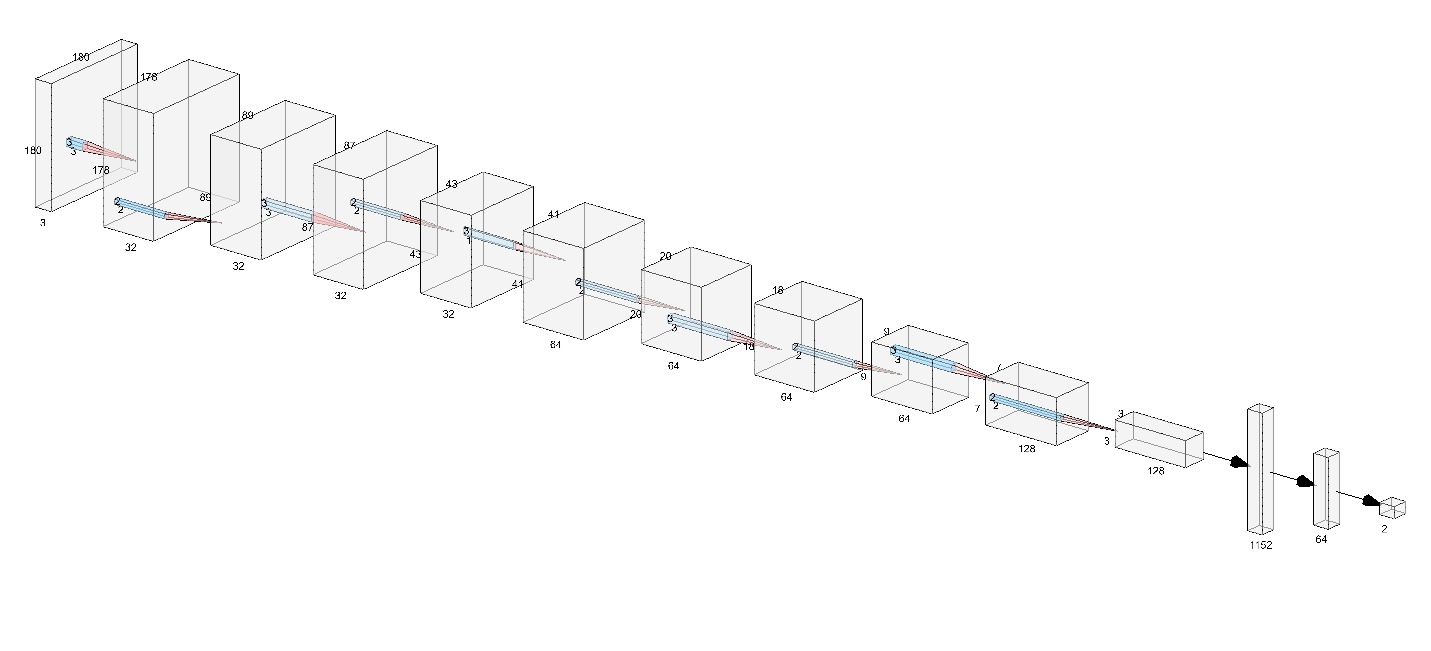

The CNN also employs BatchNorm, MaxPooling and the ReLU activation. The activation in the last layer is the softmax activation. In the dataset each image has different size so we are going to resize the images in order for them to be all 180 x 180.

In [151]:
def make_cnn(layers: list):
  inputs = keras.layers.Input((180,180,3), name='input_layer')
  x = inputs
  for i, size in enumerate(layers):
    x = keras.layers.Conv2D(size,3, name='conv_'+str(i))(x)
    x = keras.layers.BatchNormalization(name='BN_'+str(i))(x)
    x = keras.layers.ReLU(name='relu_'+str(i))(x)
    x = keras.layers.MaxPooling2D(name='maxPool_'+str(i))(x)
  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(64,activation='relu', name='dense')(x)
  outputs = keras.layers.Dense(2, activation='softmax')(x)
  return keras.Model(inputs=inputs, outputs=outputs, name='CNN')

In [170]:
model = make_cnn([32,32,64,64,128])

In [ ]:
tf.keras.utils.plot_model(model,show_shapes=True)

We are going to use a batch size of 32 to train the model, and before  training we need to prepocess the data, first by rescaling it to be between 0 and 1.0, then to resize every image to 180x180.

In [173]:
batch_size = 32
epochs = 5

def resize(x, y):
  x = tf.image.convert_image_dtype(x, tf.float32)                   #This line change the image data type 
  img =  tf.image.resize(x, [180, 180], preserve_aspect_ratio=False) #This function changes the size of each image to the desired one.
  return img, tf.cast(y, tf.float32)

ds_train = ds_train.map(
    resize)
ds_test = ds_test.map(
    resize)
ds_train = ds_train.batch(batch_size)
ds_test = ds_test.batch(batch_size)
ds_train = ds_train.prefetch(buffer_size=batch_size)
ds_test =  ds_test.prefetch(buffer_size=batch_size)

For training we will use the Adam optimizer with a learning rate of 0.001, the loss function is the SparseCategoricalCrossEntropy and the metric is accuracy.

In [174]:
model.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
              optimizer=keras.optimizers.Adam(1e-3), 
              metrics=["accuracy"])

Now we train our model for 5 epochs.

In [ ]:
history = model.fit(ds_train, epochs=epochs, validation_data=ds_test)

This is a helper function to plot different predictions.

In [176]:
def show_predictions(ds, model):
  ds = ds.unbatch()
  ds = ds.batch(1)
  ds = ds.shuffle(100,reshuffle_each_iteration=False)
  ds = ds.take(6)
  pred = model.predict(ds)
  if pred.shape[-1] == 1:
    pred = np.round(pred)
  else:
    pred = np.argmax(pred,-1)
  ax =  plt.figure(figsize=(10,10))
  for i, (img, label) in enumerate(ds):
    ax = plt.subplot(2,3,i+1)
    plt.imshow(img[0])
    if tf.constant(label[0])==0:
      label = 'cat'
    else:
      label = 'dog'
    if pred[i] < 0.5:
      plt.title('cat ('+label+')')
    else:
      plt.title('dog ('+label+')')
  return ax

In [ ]:
show_predictions(ds_test, model)

There are things we can do in order to improve the performance of our model, first we are doing random data augmentation to make the neural network more robust to position of the object and generalize better:

In [182]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
    ]
)

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in ds_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy())
        plt.axis("off")

The second thing to do is to build a deeper Neural Network, for this we are using separable convolutions and skip connections. This model is a small version of the [XCeption](https://arxiv.org/abs/1610.02357) model.

In [ ]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.Conv2D(64, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(size, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = keras.layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = keras.layers.Dropout(0.5)(x)
    outputs = keras.layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=(180,180,3), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [191]:
epochs = 1

model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
history = model.fit(
    ds_train, epochs=epochs, validation_data=ds_test,
)

This model takes longer to train so in order to gain time we have an already pre-trained model which we can load using keras.

In [ ]:
!gdown 1GSBn2K2oJfd7C0JEJaXS4qQExwTRwUrm

In [193]:
model = keras.models.load_model('cnn_pets.h5')

We now see that the accuracy of the model on test data is of 96%.

In [ ]:
model.evaluate(ds_test)

In [ ]:
show_predictions(ds_test, model)